In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
import tensorflow as tf
print(tf.version.VERSION)

2.17.0


In [ ]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git


fatal: destination path 'models' already exists and is not an empty directory.


In [ ]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt
# you may have to restart the runtime afterwards

  Preparing metadata (setup.py) ... done


In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
#from official.nlp.data import classifier_data_lib
#from official.nlp.bert import tokenization
#from official.nlp import optimization
import tensorflow_datasets as tfds
from transformers import BertTokenizer
from transformers import AdamW


In [ ]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.17.0
Eager mode:  True
Hub version:  0.16.1
GPU is NOT AVAILABLE


In [ ]:
!pip install --upgrade tensorflow
!pip install --upgrade keras
!pip install --upgrade tensorflow-addons

In [ ]:
import tensorflow._api.v2.compat.v1 as tf


In [ ]:
import numpy as np
import pandas as pd
import zipfile
import io
import requests

# Fetch the zip file from the URL
url = "https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip"
response = requests.get(url)

# Check if it's really a zip file and read the CSV inside it
with zipfile.ZipFile(io.BytesIO(response.content)) as thezip:
    with thezip.open('train.csv') as thefile:
        df = pd.read_csv(thefile)

# View the dataframe
print(df.shape)


(1306122, 3)


In [ ]:
df.tail(20)

,qid,question_text,target
1306102,ffff3778790af9baae76,What steps can I take to live a normal life if...,0
1306103,ffff3f0a2449ffe4b9ff,Isn't Trump right after all? Why should the US...,1
1306104,ffff41393389d4206066,Is 33 too late for a career in creative advert...,0
1306105,ffff42493fc203cd9532,What is difference between the filteration wor...,0
1306106,ffff48dd47bee89fff79,"If the universe ""popped"" into existence from n...",0
1306107,ffff5fd051a032f32a39,How does a shared service technology team meas...,0
1306108,ffff6d528040d3888b93,How is DSATM civil engineering?,0
1306109,ffff8776cd30cdc8d7f8,Do you know any problem that depends solely on...,0
1306110,ffff94d427ade3716cd1,What are some comic ideas for you Tube videos ...,0
1306111,ffffa382c58368071dc9,"If you had $10 million of Bitcoin, could you s...",0


<Axes: title={'center': 'target distribution'}, ylabel='Frequency'>

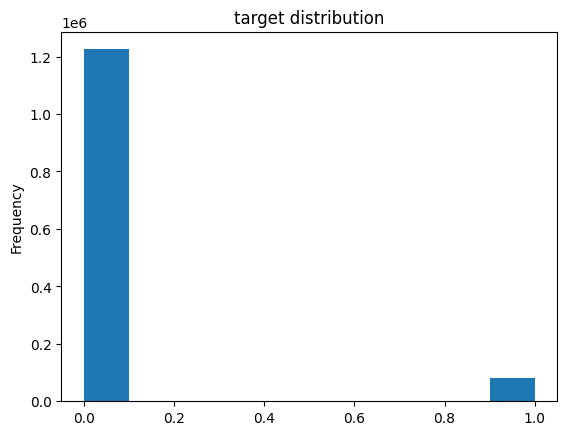

In [ ]:
df.target.plot(kind='hist', title='target distribution')

In [ ]:
from sklearn.model_selection import train_test_split

train_df, remaining = train_test_split(df, random_state=42, train_size=0.0075, stratify=df.target.values)
valid_df, _ = train_test_split(remaining, random_state=42, train_size=0.00075, stratify=remaining.target.values)

In [ ]:
valid_df.shape

(972, 3)

In [ ]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df['question_text'].values, train_df['target'].values))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_df['question_text'].values, valid_df['target'].values))
  for text, label in train_data.take(1):
    print(text)
    print(label)

tf.Tensor(b'Why are unhealthy relationships so desirable?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


In [ ]:
# @title  Download a Pre-trained BERT Model from TensorFlow Hub title text
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""

 # Label categories
 # maximum length of (token) input sequences
label_list = [0, 1] # you can get multiple label model also by changing no. of softmax units in output layer and changining binary class entropy loss to sparse categorical loss
max_seq_len = 128
batch_size = 32


# Get BERT layer and tokenizer:
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2", trainable=True)


vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
text = "Hello, how are you?"
tokens = tokenizer.tokenize(text)
print(tokens)

['hello', ',', 'how', 'are', 'you', '?']


In [ ]:
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print("Token IDs:", token_ids)

Token IDs: [7592, 1010, 2129, 2024, 2017, 1029]


In [ ]:
'''def to_feature(text, label, label_list=label_list, max_seq_len=max_seq_len, tokenizer=tokenizer):
  example = classier_data_lib.InputExample(guid=None,
                                           text_a=text.numpy(),
                                           text_b=None,
                                           label=label.numpy())
  feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_len, tokenizer)
  return (feature.imput_ids, feature.input_masks, feature.segment_ids, feature.label_ids)'''

SyntaxError: incomplete input (<ipython-input-18-7b260e226406>, line 1)

In [ ]:
def to_feature(text, label, label_list, max_seq_len=max_seq_len, tokenizer=tokenizer):
    # Tokenize the input text and encode it into input IDs, attention masks, and segment IDs
    encoding = tokenizer.encode_plus(
        text.numpy().decode('utf-8'),  # Convert the text to string if it's in TensorFlow format
        max_length=max_seq_len,
        truncation=True,
        padding='max_length',
        add_special_tokens=True,  # Adds [CLS] and [SEP]
        return_attention_mask=True,
        return_token_type_ids=True,
    )

    # Convert label into its corresponding index
    label_id = label_list.index(label.numpy().decode('utf-8'))

    # Extract and return input IDs, attention mask, token type IDs (segment IDs), and the label
    return (encoding['input_ids'], encoding['attention_mask'], encoding['token_type_ids'], label_id)


In [ ]:
def to_feature_map(label, text):
    # Use tf.py_function to call the to_feature function
    input_ids, input_masks, input_type_ids, label_id = tf.py_function(
        func=to_feature,
        inp=[text, label],
        Tout=[tf.int32, tf.int32, tf.int32, tf.int32]
    )

    # Set the shapes of the outputs
    input_ids.set_shape([max_seq_len])          # Shape for input IDs
    input_masks.set_shape([max_seq_len])        # Shape for input masks
    input_type_ids.set_shape([max_seq_len])        # Shape for segment IDs
    label_id.set_shape([])                       # Shape for label ID (single scalar)

    # Prepare the output dictionary for the model input
    x = {
        'input_word_ids': input_ids,
        'input_masks': input_masks,
        'input_type_ids': input_type_ids
    }

    return x, label_id  # Return the output dictionary and the label ID

In [ ]:
with tf.device('/cpu:0'):
  train_data = (train_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .shuffle(1000)
  .batch(32, drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE))


  valid_data = (valid_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .batch(32, drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE))


In [ ]:
train_data.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_masks': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [ ]:
valid_data.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_masks': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:

# Building the model
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_len, ), dtype=tf.int32, name='input_word_ids')
  input_mask = tf.keras.layers.Input(shape=(max_seq_len, ), dtype=tf.int32, name='input_mask')
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_len, ), dtype=tf.int32, name='input_type_ids')

  pooled_output, _ = bert_layer([input_word_ids, input_mask, input_type_ids])

  dropout1 = tf.keras.layers.Dropout(0.5, name='dropout1')(pooled_output)
  dense1 = tf.keras.layers.Dense(128, activation='relu', name='dense1')(dropout1)

  dropout2 = tf.keras.layers.Dropout(0.3, name='dropout2')(dense1)
  output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(dropout2)

  model = tf.keras.Model(
      inputs={
          'input_word_ids': input_word_ids,
          'input_mask': input_mask,
          'input_type_ids': input_type_ids
      },
      outputs=output
  )

  return model

In [ ]:
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name="input_word_ids")
  input_masks = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name="input_masks")
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name="input_type_ids")


  pooled_output, sequence_output = bert_layer([input_word_ids, input_masks, input_type_ids])

  drop = tf.keras.layers.Dropout(0.4)(pooled_output)
  output = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(drop)

  model = tf.keras.Model(
      inputs={
        'input_word_ids': input_word_ids,
        'input_masks': input_masks,
        'input_type_ids': input_type_ids
      },
      outputs=output)

  return model

In [ ]:
import tensorflow as tf

def create_model():
    input_word_ids = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name="input_word_ids")
    input_masks = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name="input_masks")
    input_type_ids = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name="input_type_ids")

    # Wrap the bert_layer call within a Lambda layer to handle Keras Tensors
    # and provide an explicit output shape.
    # This will convert the tensors to numpy before passing them to the bert_layer
    # Assuming bert_layer outputs two tensors: pooled_output, sequence_output
    # Modify output_shape according to the actual output shape of your bert_layer
    bert_outputs = tf.keras.layers.Lambda(
        lambda inputs: bert_layer(inputs), # bert_layer expects numpy array here
        output_shape=[(None, 768), (None, max_seq_len, 768)],  # Adjust output_shape as needed
        name="bert_layer_wrapper"
    )([input_word_ids, input_masks, input_type_ids])

    pooled_output = bert_outputs[0] # Extract the pooled output

    drop = tf.keras.layers.Dropout(0.4)(pooled_output)
    output = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(drop)

    model = tf.keras.Model(
        inputs={
            'input_word_ids': input_word_ids,
            'input_masks': input_masks,
            'input_type_ids': input_type_ids
        },
        outputs=output)

    return model

In [ ]:

model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_word_ids            │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_masks (InputLayer)  │ (None, 128)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_type_ids            │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_layer_wrapper        │ [(None, None, 768),    │              0 │ input_word_ids[0][0],  │
│ (Lambda)                  │ (None, None, 128,      │                │ input_masks[0][0],     │
│                           │ 768)]                  │                │ input_type_ids[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, None, 768)      │              0 │ bert_layer_wrapper[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, None, 1)        │            769 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 769 (3.00 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)

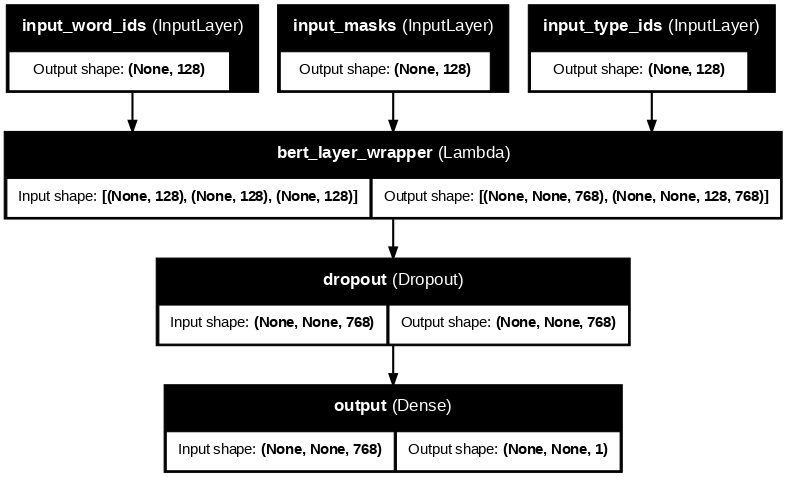

In [ ]:
tf.keras.utils.plot_model(model=model, show_shapes=True, show_layer_names=True, dpi=76)

In [ ]:
epochs = 4
history = model.fit(train_data, validation_data=valid_data, epochs=epochs, verbose=1)

In [ ]:

import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()


In [ ]:
print(history.history)

In [ ]:
plot_graphs(history, 'loss')

In [ ]:
plot_graphs(history, 'binary_accuracy')

In [ ]:

sample_example = ['...', 'hello dear friend']

test_data = tf.data.Dataset.from_tensor_slices((sample_example, [0]*len(sample_example)))
test_data = (test_data.map(to_feature_map).batch(1))
preds = model.predict(test_data)

['Insincere' if pred>= 0.5 else 'Sincere' for pred in preds]